# Joint data analysis

This will be the notebook in which I will conduct my joint data analysis.
The idea is that I can use my JOD data as well as my quantitative data from the cluster in order to formulate some joint statements about my model performance.

In [158]:
import pandas as pd

df_jod = pd.read_excel("data/jod.xlsx")
df_metrics = pd.read_excel("data/singleMetricResultClean.xlsx")

### Correlation Analysis

So given my JOD values, what kind of correlation could I even compute?

For each facet of my data I can create scatterplot where one observation is a method.

#### Correlation analysis by facet

In [159]:
from typing import Dict
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, norm, spearmanr
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def compute_linear_rmse(x, y) -> float:
    X = x.values.reshape(-1, 1)  # Reshape for sklearn
    y = y.values

    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
    return rmse_linear


def compute_nonlinear_rmse(x, y) -> float:
    X = x.values.reshape(-1, 1)  # Reshape for sklearn
    y = y.values

    # Nonlinear (Quadratic) Regression
    X_nonlinear = np.column_stack((X, X**2))  # Add x^2 term
    nonlinear_model = (
        LinearRegression()
    )  # Still use linear regression, but with transformed features
    nonlinear_model.fit(X_nonlinear, y)
    y_pred_nonlinear = nonlinear_model.predict(X_nonlinear)
    rmse_nonlinear = np.sqrt(mean_squared_error(y, y_pred_nonlinear))
    return rmse_nonlinear


def compute_spearman(x, y) -> float:
    corr, _ = spearmanr(x, y)
    return corr


def compute_pearsonr(x, y) -> float:
    corr, _ = pearsonr(x, y)
    return corr


def plot_quality_metric_against_jod_by_facet(quality_metric: str = "psnr") -> None:
    fig, axs = plt.subplots(3, 3)

    for i, dataset in enumerate(df_metrics["dataset"].unique()):
        for j, size in enumerate(["low", "medium", "high"]):
            single_facet_df = join_quality_metrics_by_facet(
                quality_metric, dataset, size
            )
            axs[i][j].scatter(single_facet_df["jod"], single_facet_df[quality_metric])

    fig.suptitle(quality_metric)
    plt.show()


def plot_quality_metric_against_jod(quality_metric: str = "psnr") -> None:
    df = join_quality_metrics(quality_metric)
    plt.scatter(df["jod"], df[quality_metric])

    plt.suptitle(quality_metric)
    plt.show()

def join_quality_metrics(quality_metric: str) -> pd.DataFrame:
    df_jod_agg = df_jod.melt(
        id_vars=["dataset", "size"],
        value_vars=[
            "default",
            "mcmc",
            "mini_splatting",
            "eagles",
            "mip_splatting",
            "gaussian_pro",
            "geo_gaussian",
        ],
    ).rename({"variable": "model", "value": "jod"}, axis=1)
    df_jod_agg["model"] = df_jod_agg["model"].apply(lambda x: x.replace("_", "-"))
    df_jod_agg = df_jod_agg.set_index(["model", "dataset", "size"])
    df_metrics_agg = df_metrics.groupby(["model", "dataset", "size"])[[quality_metric]].mean()
    return df_jod_agg.join(df_metrics_agg)

def join_quality_metrics_by_facet(
    quality_metric: str, dataset: str, size: str
) -> pd.DataFrame:
    single_facet_df = (
        df_jod[(df_jod["dataset"] == dataset) & (df_jod["size"] == size)]
        .transpose()
        .iloc[3:]
        .rename(lambda x: "jod", axis=1)
    )
    metrics_df = aggregate_metrics_by_facet(quality_metric, dataset, size)
    single_facet_df = single_facet_df.join(metrics_df)
    return single_facet_df


def create_correlation_dataframe_by_facet(quality_metric: str = "psnr") -> pd.DataFrame:
    records = []
    for dataset in df_metrics["dataset"].unique():
        for size in ["low", "medium", "high"]:
            single_facet_df = join_quality_metrics_by_facet(
                quality_metric, dataset, size
            )
            records.append(
                create_record(quality_metric, single_facet_df, dataset, size)
            )
    return pd.DataFrame.from_records(records)


def create_record(
    quality_metric: str,
    df: pd.DataFrame,
    dataset: str = None,
    size: str = None,
) -> Dict:
    record = {
        "SROCC": compute_spearman(df["jod"], df[quality_metric]),
        "PLCC": compute_pearsonr(
            df["jod"].astype(np.float32),
            df[quality_metric].astype(np.float32),
        ),
        "RMSE_lin": compute_linear_rmse(
            df["jod"],
            df[quality_metric],
        ),
        "RMSE_cub": compute_nonlinear_rmse(
            df["jod"],
            df[quality_metric],
        ),
    }

    if dataset is not None:
        record["dataset"] = dataset
    if size is not None:
        record["size"] = size

    return record


def aggregate_metrics(quality_metric: str) -> pd.DataFrame:
    if quality_metric == "brisque":
        metric_single_facet = (
            df_metrics.melt(
                id_vars=["model", "dataset", "size", "view_idx"],
                value_vars=[
                    "brisque",
                    "brisque_0",
                    "brisque_1",
                    "brisque_2",
                    "brisque_3",
                    "brisque_4",
                ],
            )
            .groupby(["model", "dataset", "size"])["value"]
            .mean()
        )
    else:
        metric_single_facet = df_metrics.groupby(["model", "dataset", "size"])[
            quality_metric
        ].mean()
    metrics_df = pd.DataFrame.from_dict(
        {
            "technique": [
                technique.replace("-", "_")
                for technique, _, _ in metric_single_facet.index
            ],
            quality_metric: metric_single_facet.values,
        }
    ).set_index("technique")

    return metrics_df


def aggregate_metrics_by_facet(
    quality_metric: str, dataset: str, size: str
) -> pd.DataFrame:
    if quality_metric == "brisque":
        metric_single_facet = (
            df_metrics[
                (df_metrics["dataset"] == dataset) & (df_metrics["size"] == size)
            ]
            .melt(
                id_vars=["model", "dataset", "size", "view_idx"],
                value_vars=[
                    "brisque",
                    "brisque_0",
                    "brisque_1",
                    "brisque_2",
                    "brisque_3",
                    "brisque_4",
                ],
            )
            .groupby(["model", "dataset", "size"])["value"]
            .mean()
        )
    else:
        metric_single_facet = (
            df_metrics[
                (df_metrics["dataset"] == dataset) & (df_metrics["size"] == size)
            ]
            .groupby(["model", "dataset", "size"])[quality_metric]
            .mean()
        )
    metrics_df = pd.DataFrame.from_dict(
        {
            "technique": [
                technique.replace("-", "_")
                for technique, _, _ in metric_single_facet.index
            ],
            quality_metric: metric_single_facet.values,
        }
    ).set_index("technique")

    return metrics_df

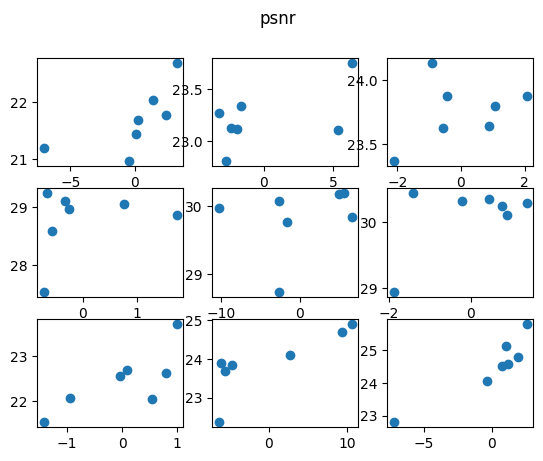

In [160]:
plot_quality_metric_against_jod_by_facet()
df_psnr = create_correlation_dataframe_by_facet()

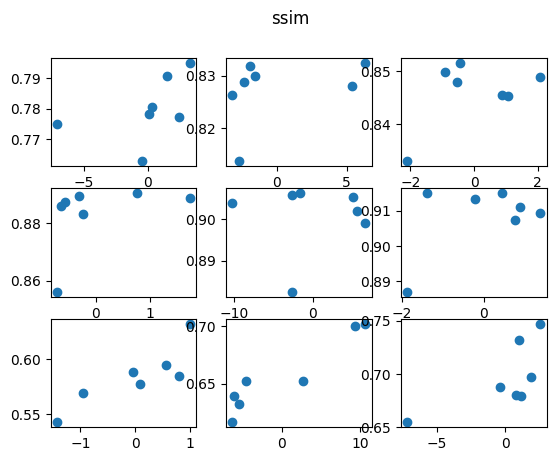

In [161]:
plot_quality_metric_against_jod_by_facet("ssim")
df_ssim = create_correlation_dataframe_by_facet("ssim")

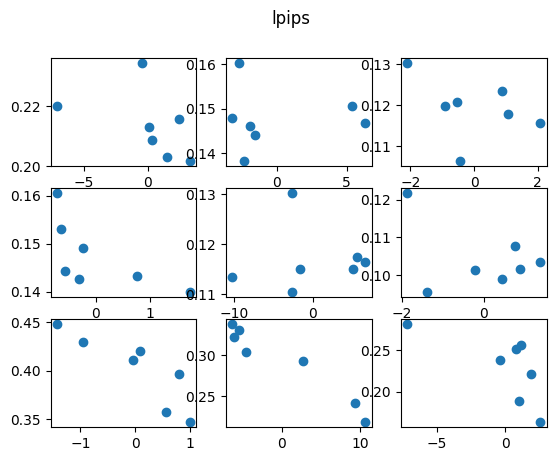

In [162]:
plot_quality_metric_against_jod_by_facet("lpips")
df_lpips = create_correlation_dataframe_by_facet("lpips")

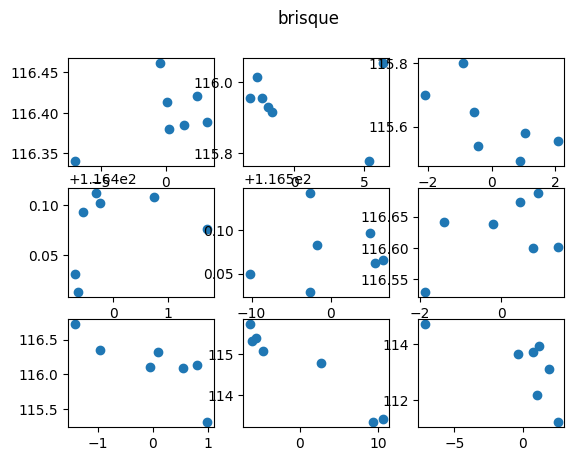

In [163]:
plot_quality_metric_against_jod_by_facet("brisque")
df_brisque = create_correlation_dataframe_by_facet("brisque")

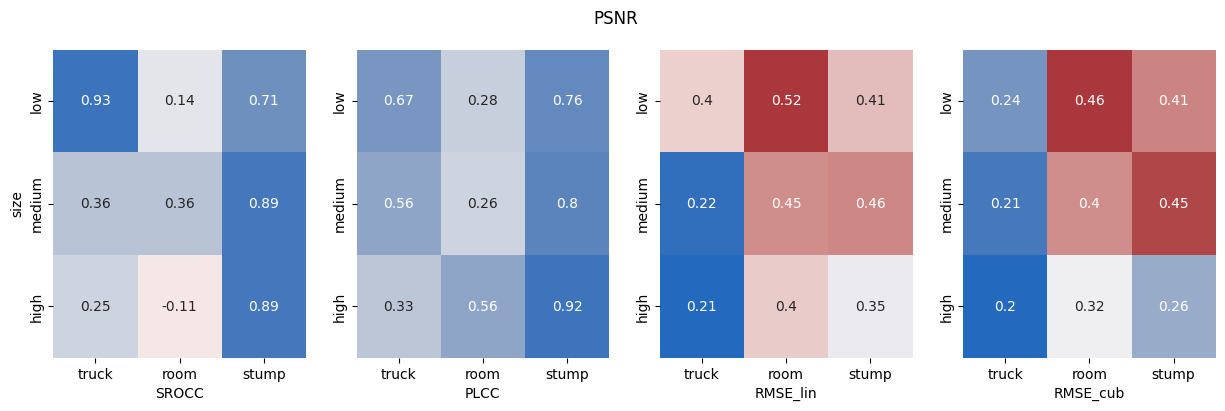

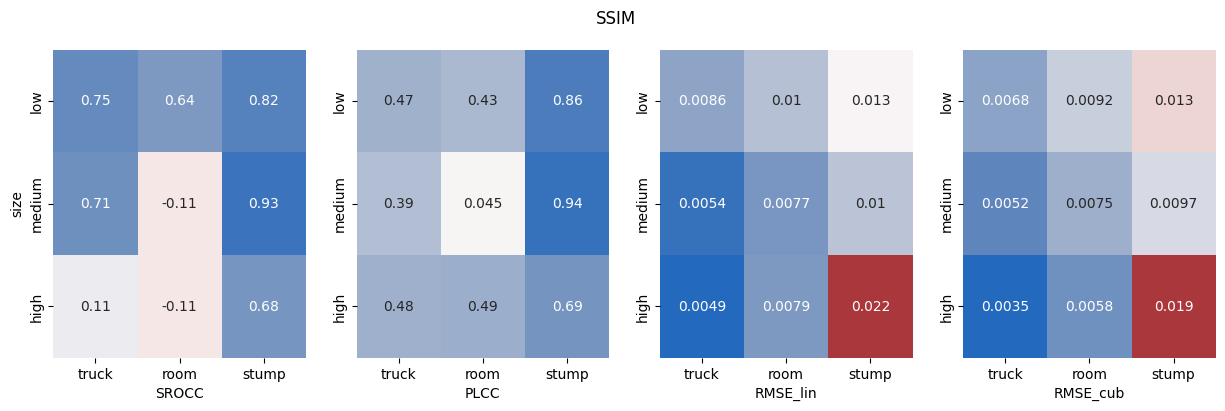

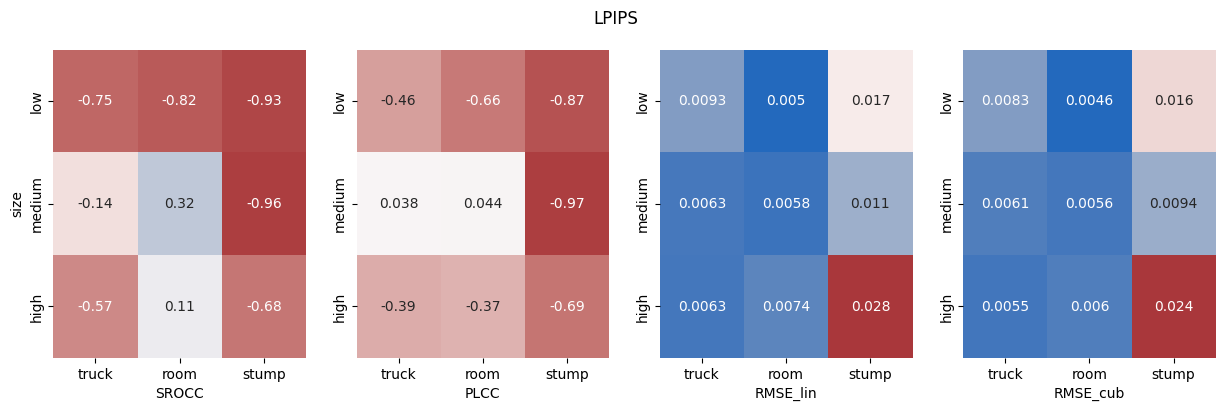

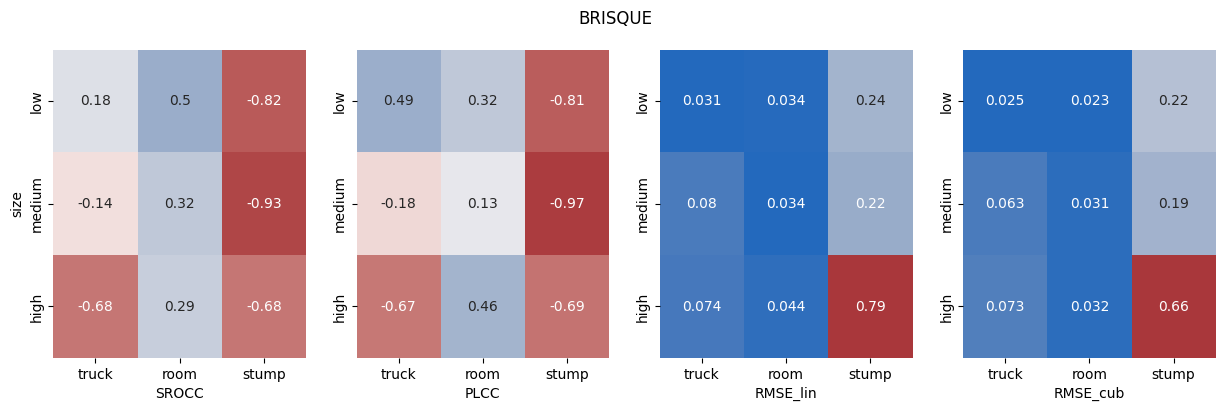

In [164]:
import seaborn as sns


def plot_heatmap_for_metrics(dataframe: pd.DataFrame, title: str):
    metrics = ["SROCC", "PLCC", "RMSE_lin", "RMSE_cub"]

    fig, axs = plt.subplots(1, len(metrics), figsize=(15, 4))

    for i, metric in enumerate(metrics):
        df_pivot = dataframe[[metric, "size", "dataset"]]
        df_pivot = pd.pivot(
            df_pivot, columns=["dataset"], index=["size"], values=[metric]
        )
        df_pivot.columns = df_pivot.columns.map(lambda x: x[1])
        df_pivot.index = pd.CategoricalIndex(
            df_pivot.index, categories=["low", "medium", "high"], ordered=True
        )
        df_pivot.sort_index(inplace=True)
        cmap = sns.color_palette("vlag", as_cmap=True).reversed()
        if "RMSE" in metric:
           cmap = cmap.reversed()
        sns.heatmap(
            df_pivot[["truck", "room", "stump"]],
            annot=True,
            ax=axs[i],
            cbar=False,
            cmap=cmap,
            vmin=None if "RMSE" in metric else -1,
            vmax=None if "RMSE" in metric else 1,
        )
        axs[i].set_xlabel(metric)
        if i > 0:
            axs[i].set_ylabel("")

    fig.suptitle(title)
    plt.show()


plot_heatmap_for_metrics(df_psnr, "PSNR")
plot_heatmap_for_metrics(df_ssim, "SSIM")
plot_heatmap_for_metrics(df_lpips, "LPIPS")
plot_heatmap_for_metrics(df_brisque, "BRISQUE")

#### Correlation analysis without facets

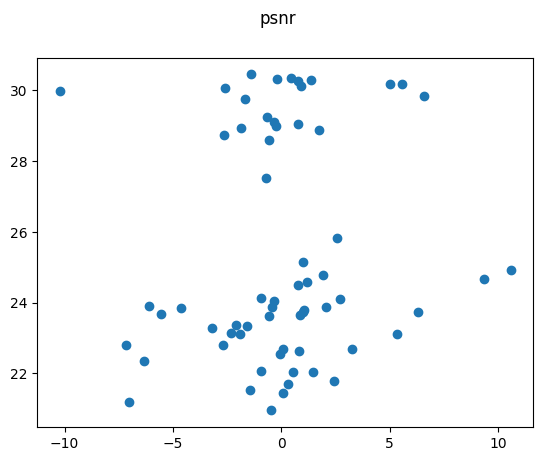

In [165]:
plot_quality_metric_against_jod("psnr")

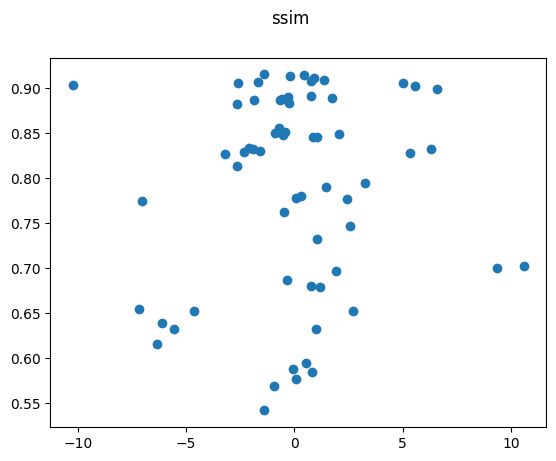

In [166]:
plot_quality_metric_against_jod("ssim")

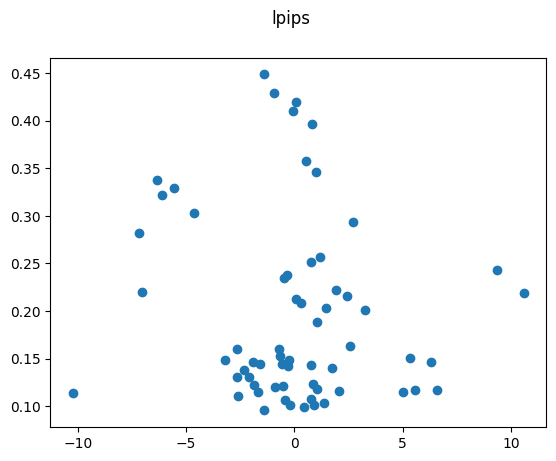

In [167]:
plot_quality_metric_against_jod("lpips")

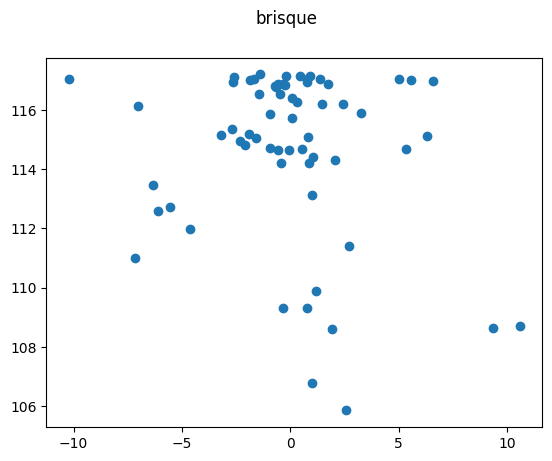

In [168]:
plot_quality_metric_against_jod("brisque")

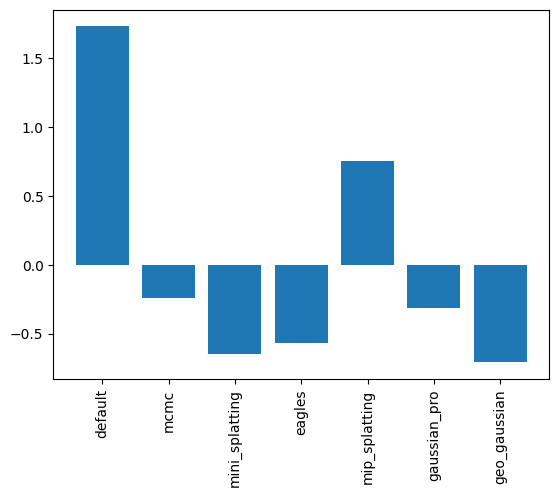

In [169]:
from matplotlib import pyplot as plt

df = df_jod[(df_jod["dataset"] == "room") & (df_jod["size"] == "low")].transpose().iloc[3:]

plt.bar(df.index, df[0])
plt.xticks(rotation=90)
plt.show()


In [170]:
psnr_single_facet = df_metrics[(df_metrics["dataset"] == "room") & (df_metrics["size"] == "low")].groupby(["model", "dataset", "size"])["psnr"].median()

In [171]:
psnr_single_facet

model           dataset  size
default         room     low     28.898587
eagles          room     low     29.261131
gaussian-pro    room     low     29.310398
geo-gaussian    room     low     28.178413
mcmc            room     low     29.038901
mini-splatting  room     low     29.608626
mip-splatting   room     low     28.971822
Name: psnr, dtype: float64

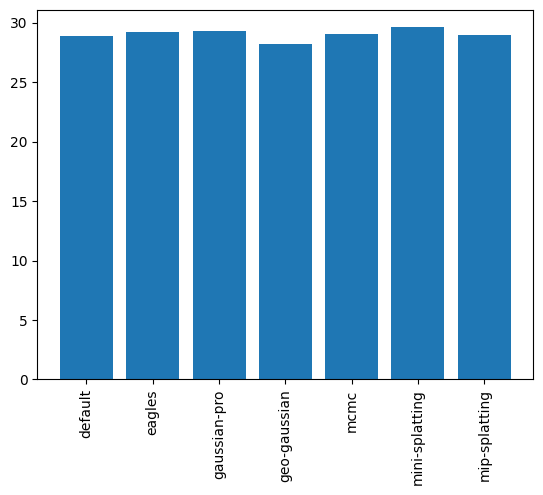

In [172]:
plt.bar([technique for technique, _ , _ in psnr_single_facet.index], psnr_single_facet.values)
plt.xticks(rotation=90)
plt.show()